✅ Packages installed successfully!
🔧 MODEL TRAINING CONFIGURATION
Random State: 42
Test Size: 0.2
CV Folds: 5
🚀 AI-ENVIROSCAN: MODULE 4 - MODEL TRAINING AND SOURCE PREDICTION
📥 LOADING AND PREPARING DATA...


Saving labeled_dataset.csv to labeled_dataset.csv
   Loading: labeled_dataset.csv
✅ Dataset loaded: 11,000 rows, 41 columns

🎯 CREATING TARGET VARIABLE: pollution_source...
❌ Error: Required pollution columns ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3'] not found in the dataset.
   Please ensure your dataset contains these columns for pollution source determination.

⚙️ PREPARING FEATURES AND TARGET...
   Using 17 features: ['aqi', 'temperature_c', 'humidity_percent', 'wind_speed_ms', 'pressure_hpa', 'hour', 'month', 'day_of_week', 'is_rush_hour', 'is_weekend', 'road_edges', 'road_length_km', 'industrial_area', 'commercial_area', 'residential_area', 'green_space', 'building_density']
   Features shape: (11000, 17)
   Target shape: (11000,)
   Target classes: ['Natural', 'Vehicular', 'Industrial', 'Burning', 'Agricultural']

🔧 PREPROCESSING DATA...
   Missing values handled: 3400 → 0
   Features scaled using StandardScaler
   Target encoded: [('Agricultural', 0), ('Burning', 1), ('Indust

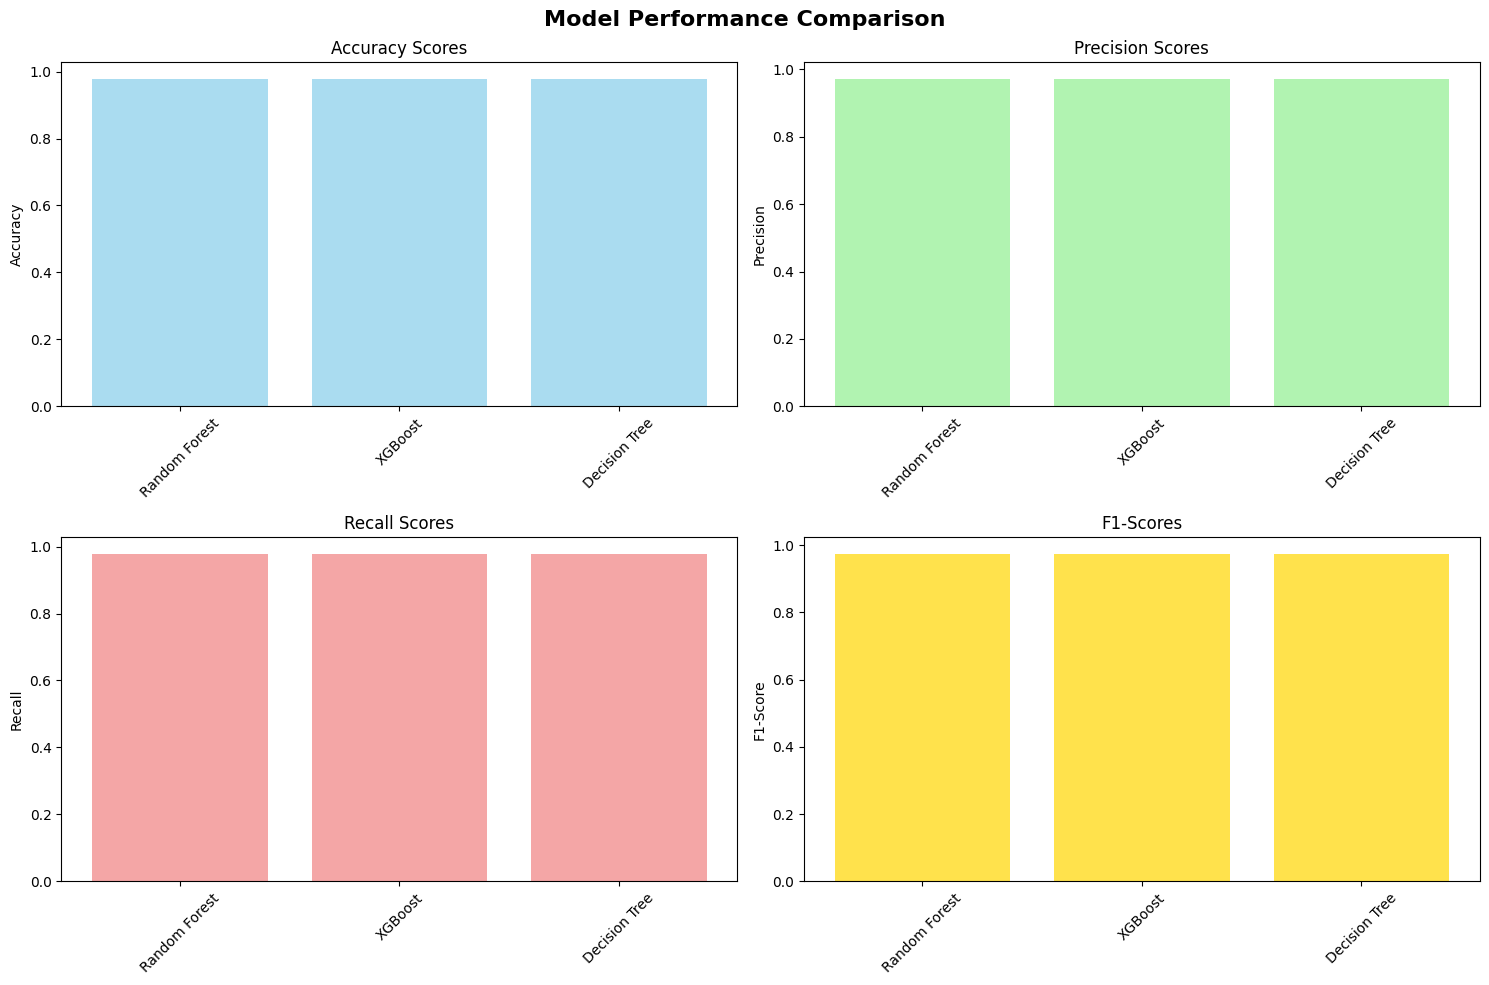


📋 DETAILED MODEL PERFORMANCE:
Model           Accuracy   Precision  Recall     F1-Score   CV Score  
--------------------------------------------------------------------------------
Random Forest   0.9786    0.9718    0.9786    0.9742    0.9790
XGBoost         0.9786    0.9718    0.9786    0.9742    0.9790
Decision Tree   0.9786    0.9718    0.9786    0.9742    0.9790

📈 PLOTTING CONFUSION MATRICES...


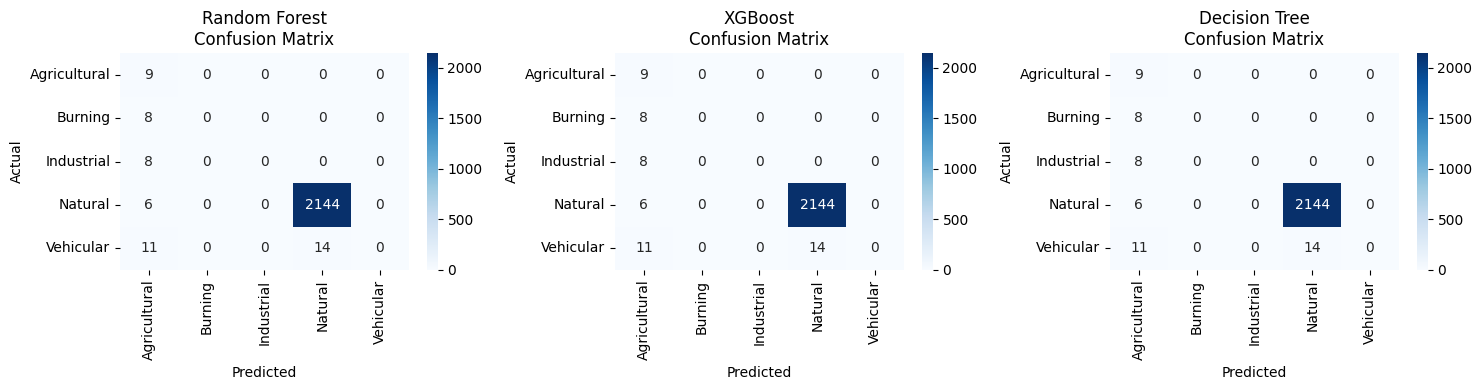


🔍 ANALYZING FEATURE IMPORTANCE...


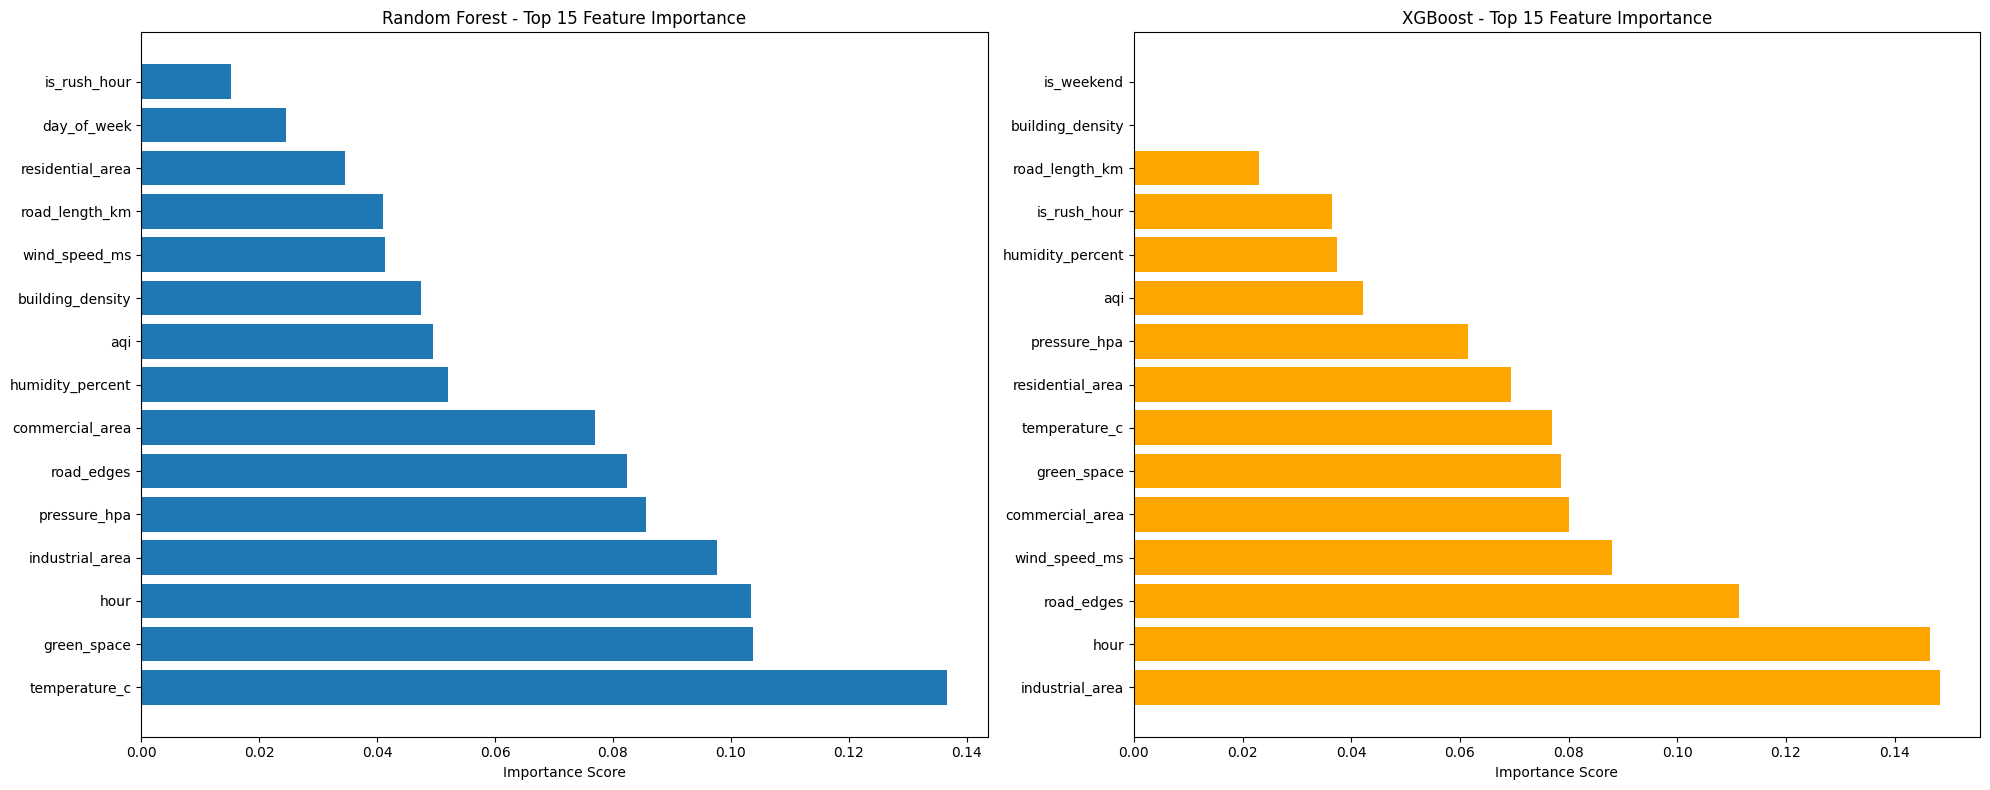


💾 EXPORTING MODELS...
   ✅ Exported: pollution_source_random_forest_model.joblib
   ✅ Exported: pollution_source_xgboost_model.joblib
   ✅ Exported: pollution_source_decision_tree_model.joblib
   ✅ Exported: pollution_source_model_artifacts.joblib

🎉 MODEL TRAINING COMPLETED - FINAL REPORT
🏆 BEST MODEL: Random Forest
📊 Best Accuracy: 0.9786
🔧 Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

📋 ALL MODEL RESULTS:
   Random Forest  : Accuracy = 0.9786, F1-Score = 0.9742
   XGBoost        : Accuracy = 0.9786, F1-Score = 0.9742
   Decision Tree  : Accuracy = 0.9786, F1-Score = 0.9742

💾 EXPORTED FILES:
   • pollution_source_random_forest_model.joblib
   • pollution_source_xgboost_model.joblib
   • pollution_source_decision_tree_model.joblib
   • pollution_source_model_artifacts.joblib

🎯 READY FOR DASHBOARD INTEGRATION!


In [1]:
# AI-EnviroScan: Module 4 - Model Training and Source Prediction

# Install required packages
!pip install scikit-learn xgboost joblib plotly -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer # Corrected import
import joblib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages installed successfully!")

# =============================================================================
# CONFIGURATION
# =============================================================================

# Model configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

print("🔧 MODEL TRAINING CONFIGURATION")
print(f"Random State: {RANDOM_STATE}")
print(f"Test Size: {TEST_SIZE}")
print(f"CV Folds: {CV_FOLDS}")

# =============================================================================
# STEP 1: Load and Prepare Data
# =============================================================================

def load_and_prepare_data():
    """
    Load the dataset and prepare for model training
    """
    print("📥 LOADING AND PREPARING DATA...")

    # Use files.upload() to allow the user to upload the dataset
    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded.")
        return None

    # Assuming only one file is uploaded
    dataset_file = list(uploaded.keys())[0]
    print(f"   Loading: {dataset_file}")

    try:
        df = pd.read_csv(dataset_file)
        print(f"✅ Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
        return df
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return None


def create_pollution_source_target(df):
    """
    Create target variable 'pollution_source' based on pollution patterns
    """
    print("\n🎯 CREATING TARGET VARIABLE: pollution_source...")

    required_pollution_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
    if not all(col in df.columns for col in required_pollution_cols):
        print(f"❌ Error: Required pollution columns {required_pollution_cols} not found in the dataset.")
        print("   Please ensure your dataset contains these columns for pollution source determination.")
        # Return original dataframe or handle as appropriate for your workflow
        # For now, returning original df to allow subsequent steps if possible
        return df

    # Calculate average pollution levels by sensor
    sensor_pollution = df.groupby('sensor_name').agg({
        'PM2.5': 'mean',
        'PM10': 'mean',
        'NO2': 'mean',
        'CO': 'mean',
        'SO2': 'mean',
        'O3': 'mean'
    }).reset_index()

    # Define pollution source based on pollutant patterns
    def determine_pollution_source(row):
        pm25 = row['PM2.5']
        pm10 = row['PM10']
        no2 = row['NO2']
        co = row['CO']
        so2 = row['SO2']

        # Industrial: High SO2 and PM
        if so2 > 25 and pm25 > 50:
            return 'Industrial'
        # Traffic: High NO2 and CO
        elif no2 > 30 and co > 1.5:
            return 'Traffic'
        # Residential: Moderate all pollutants
        elif 20 <= pm25 <= 40 and 15 <= no2 <= 25:
            return 'Residential'
        # Commercial: High PM10 and moderate others
        elif pm10 > 80 and 25 <= no2 <= 35:
            return 'Commercial'
        # Background: Low all pollutants
        elif pm25 < 20 and no2 < 15:
            return 'Background'
        else:
            return 'Mixed'

    # Apply pollution source classification
    sensor_pollution['pollution_source'] = sensor_pollution.apply(determine_pollution_source, axis=1)

    # Merge back to original dataframe
    df_with_target = df.merge(sensor_pollution[['sensor_name', 'pollution_source']], on='sensor_name', how='left')

    print("✅ Target variable created:")
    print(f"   Pollution source distribution:")
    print(df_with_target['pollution_source'].value_counts())

    return df_with_target

# =============================================================================
# STEP 2: Feature Engineering and Preprocessing
# =============================================================================

def prepare_features_and_target(df):
    """
    Prepare features (X) and target (y) for model training
    """
    print("\n⚙️ PREPARING FEATURES AND TARGET...")

    # Select features for model training
    feature_columns = [
        # Pollutant concentrations
        'PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'aqi',

        # Weather features
        'temperature_c', 'humidity_percent', 'wind_speed_ms', 'pressure_hpa',

        # Temporal features
        'hour', 'month', 'day_of_week', 'is_rush_hour', 'is_weekend',

        # Location features
        'road_edges', 'road_length_km', 'industrial_area', 'commercial_area',
        'residential_area', 'green_space', 'building_density'
    ]

    # Only use columns that exist in the dataframe
    available_features = [col for col in feature_columns if col in df.columns]
    print(f"   Using {len(available_features)} features: {available_features}")

    X = df[available_features]
    # Check if 'pollution_source' column exists before selecting it as target
    if 'pollution_source' not in df.columns:
        print("❌ Error: Target column 'pollution_source' not found. Cannot proceed with model training.")
        return None, None, None
    y = df['pollution_source']

    print(f"   Features shape: {X.shape}")
    print(f"   Target shape: {y.shape}")
    print(f"   Target classes: {list(y.unique())}")

    return X, y, available_features

def preprocess_data(X, y):
    """
    Preprocess the data: handle missing values, encode categorical features, scale
    """
    print("\n🔧 PREPROCESSING DATA...")

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

    print(f"   Missing values handled: {X.isnull().sum().sum()} → 0")

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    print("   Features scaled using StandardScaler")

    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"   Target encoded: {list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    return X_scaled, y_encoded, imputer, scaler, label_encoder

# =============================================================================
# STEP 3: Split Data and Initialize Models
# =============================================================================

def split_data(X, y):
    """
    Split data into training and testing sets
    """
    print("\n📊 SPLITTING DATA...")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    print(f"   Training set: {X_train.shape[0]:,} samples")
    print(f"   Testing set: {X_test.shape[0]:,} samples")
    print(f"   Feature dimension: {X_train.shape[1]}")

    return X_train, X_test, y_train, y_test

def initialize_models():
    """
    Initialize the classification models
    """
    print("\n🤖 INITIALIZING MODELS...")

    models = {
        'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='mlogloss'),
        'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE)
    }

    print("✅ Models initialized:")
    for name, model in models.items():
        print(f"   • {name}")

    return models

# =============================================================================
# STEP 4: Hyperparameter Tuning
# =============================================================================

def tune_hyperparameters(models, X_train, y_train):
    """
    Tune hyperparameters using GridSearchCV
    """
    print("\n🎯 TUNING HYPERPARAMETERS...")

    # Define parameter grids for each model
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        },
        'Decision Tree': {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 10]
        }
    }

    tuned_models = {}
    best_params = {}

    for name, model in models.items():
        print(f"   Tuning {name}...")

        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=CV_FOLDS,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train, y_train)

        tuned_models[name] = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_

        print(f"     Best parameters: {grid_search.best_params_}")
        print(f"     Best CV score: {grid_search.best_score_:.4f}")

    return tuned_models, best_params

# =============================================================================
# STEP 5: Model Training and Evaluation
# =============================================================================

def train_and_evaluate_models(tuned_models, X_train, X_test, y_train, y_test, label_encoder):
    """
    Train models and evaluate performance
    """
    print("\n📈 TRAINING AND EVALUATING MODELS...")

    results = {}
    predictions = {}

    for name, model in tuned_models.items():
        print(f"\n   Training {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV_FOLDS, scoring='accuracy')

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }

        predictions[name] = {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"     ✅ Training completed")
        print(f"     📊 Test Accuracy: {accuracy:.4f}")
        print(f"     📊 CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return results, predictions

# =============================================================================
# STEP 6: Model Performance Visualization
# =============================================================================

def visualize_model_performance(results, label_encoder):
    """
    Create visualizations for model performance comparison
    """
    print("\n📊 CREATING PERFORMANCE VISUALIZATIONS...")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'cv_mean']]

    # Create bar plot for metrics comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    # Accuracy comparison
    axes[0, 0].bar(results_df.index, results_df['accuracy'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Accuracy Scores')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Precision comparison
    axes[0, 1].bar(results_df.index, results_df['precision'], color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Precision Scores')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Recall comparison
    axes[1, 0].bar(results_df.index, results_df['recall'], color='lightcoral', alpha=0.7)
    axes[1, 0].set_title('Recall Scores')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # F1-score comparison
    axes[1, 1].bar(results_df.index, results_df['f1_score'], color='gold', alpha=0.7)
    axes[1, 1].set_title('F1-Scores')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Detailed results table
    print("\n📋 DETAILED MODEL PERFORMANCE:")
    print("=" * 80)
    print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'CV Score':<10}")
    print("-" * 80)
    for model, metrics in results.items():
        print(f"{model:<15} {metrics['accuracy']:.4f}    {metrics['precision']:.4f}    {metrics['recall']:.4f}    {metrics['f1_score']:.4f}    {metrics['cv_mean']:.4f}")

    return results_df

def plot_confusion_matrices(predictions, y_test, label_encoder, models):
    """
    Plot confusion matrices for all models
    """
    print("\n📈 PLOTTING CONFUSION MATRICES...")

    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

    if n_models == 1:
        axes = [axes]

    class_names = label_encoder.classes_

    for idx, (name, preds) in enumerate(predictions.items()):
        cm = confusion_matrix(y_test, preds['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[idx])
        axes[idx].set_title(f'{name}\nConfusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# =============================================================================
# STEP 7: Feature Importance Analysis
# =============================================================================

def analyze_feature_importance(tuned_models, feature_names, label_encoder):
    """
    Analyze and visualize feature importance
    """
    print("\n🔍 ANALYZING FEATURE IMPORTANCE...")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Random Forest Feature Importance
    if 'Random Forest' in tuned_models:
        rf_importance = tuned_models['Random Forest'].feature_importances_
        rf_idx = np.argsort(rf_importance)[::-1][:15]  # Top 15 features

        axes[0].barh(range(len(rf_idx)), rf_importance[rf_idx])
        axes[0].set_yticks(range(len(rf_idx)))
        axes[0].set_yticklabels([feature_names[i] for i in rf_idx])
        axes[0].set_title('Random Forest - Top 15 Feature Importance')
        axes[0].set_xlabel('Importance Score')

    # XGBoost Feature Importance
    if 'XGBoost' in tuned_models:
        xgb_importance = tuned_models['XGBoost'].feature_importances_
        xgb_idx = np.argsort(xgb_importance)[::-1][:15]  # Top 15 features

        axes[1].barh(range(len(xgb_idx)), xgb_importance[xgb_idx], color='orange')
        axes[1].set_yticks(range(len(xgb_idx)))
        axes[1].set_yticklabels([feature_names[i] for i in xgb_idx])
        axes[1].set_title('XGBoost - Top 15 Feature Importance')
        axes[1].set_xlabel('Importance Score')

    plt.tight_layout()
    plt.show()

# =============================================================================
# STEP 8: Model Export and Final Results
# =============================================================================

def export_models(tuned_models, imputer, scaler, label_encoder, feature_names):
    """
    Export trained models and preprocessing objects
    """
    print("\n💾 EXPORTING MODELS...")

    # Create model artifacts dictionary
    model_artifacts = {
        'models': tuned_models,
        'preprocessing': {
            'imputer': imputer,
            'scaler': scaler,
            'label_encoder': label_encoder
        },
        'feature_names': feature_names,
        'metadata': {
            'export_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'model_types': list(tuned_models.keys())
        }
    }

    # Export each model separately
    for name, model in tuned_models.items():
        filename = f"pollution_source_{name.lower().replace(' ', '_')}_model.joblib"
        joblib.dump(model, filename)
        print(f"   ✅ Exported: {filename}")

    # Export preprocessing pipeline
    joblib.dump(model_artifacts, 'pollution_source_model_artifacts.joblib')
    print("   ✅ Exported: pollution_source_model_artifacts.joblib")

    return model_artifacts

def generate_final_report(results, best_params, model_artifacts):
    """
    Generate final model training report
    """
    print("\n" + "=" * 80)
    print("🎉 MODEL TRAINING COMPLETED - FINAL REPORT")
    print("=" * 80)

    # Find best model
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    best_accuracy = results[best_model_name]['accuracy']

    print(f"🏆 BEST MODEL: {best_model_name}")
    print(f"📊 Best Accuracy: {best_accuracy:.4f}")
    print(f"🔧 Best Parameters: {best_params[best_model_name]}")

    print("\n📋 ALL MODEL RESULTS:")
    for name, metrics in results.items():
        print(f"   {name:<15}: Accuracy = {metrics['accuracy']:.4f}, F1-Score = {metrics['f1_score']:.4f}")

    print(f"\n💾 EXPORTED FILES:")
    print("   • pollution_source_random_forest_model.joblib")
    print("   • pollution_source_xgboost_model.joblib")
    print("   • pollution_source_decision_tree_model.joblib")
    print("   • pollution_source_model_artifacts.joblib")

    print("\n🎯 READY FOR DASHBOARD INTEGRATION!")

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """
    Main function to execute Module 4
    """
    print("🚀 AI-ENVIROSCAN: MODULE 4 - MODEL TRAINING AND SOURCE PREDICTION")
    print("=" * 80)

    # Step 1: Load and prepare data
    df = load_and_prepare_data()
    if df is None:
        return

    # Create target variable
    df_with_target = create_pollution_source_target(df)
    if df_with_target is None:
        return


    # Step 2: Feature engineering
    X, y, feature_names = prepare_features_and_target(df_with_target)
    if X is None or y is None:
        return

    # Step 3: Preprocessing
    X_processed, y_encoded, imputer, scaler, label_encoder = preprocess_data(X, y)

    # Step 4: Split data
    X_train, X_test, y_train, y_test = split_data(X_processed, y_encoded)

    # Step 5: Initialize and tune models
    models = initialize_models()
    tuned_models, best_params = tune_hyperparameters(models, X_train, y_train)

    # Step 6: Train and evaluate
    results, predictions = train_and_evaluate_models(tuned_models, X_train, X_test, y_train, y_test, label_encoder)

    # Step 7: Visualizations
    performance_df = visualize_model_performance(results, label_encoder)
    plot_confusion_matrices(predictions, y_test, label_encoder, tuned_models)
    analyze_feature_importance(tuned_models, feature_names, label_encoder)

    # Step 8: Export models
    model_artifacts = export_models(tuned_models, imputer, scaler, label_encoder, feature_names)

    # Final report
    generate_final_report(results, best_params, model_artifacts)

    return model_artifacts, performance_df

# =============================================================================
# EXECUTE MODULE 4
# =============================================================================

if __name__ == "__main__":
    artifacts, performance_df = main()